# Handwritten Hebrew Letters Image Classification

## By: Grant Kazan

### Adapted from work by: Irina Rabaev, Berat Kurar Barakat, Alexander Churkin, and Jihad El-Sana

## Background

Image classification is a typical use case for convolutional neural networks (CNN) with the MNIST handwritten digit dataset commonly used for CNN education. 

While Kaggle has datasets for languages like English, Chinese, and Arabic, there isn’t a similar set for Hebrew. 

This project is the first Handwritten Hebrew Character Classification task on Kaggle. Additionally, other lesser-represented writing systems of the world can use a similar workflow to ensure their language can be both, represented on Kaggle and used for machine learning.


## Objective

In 2020, a team of computer scientists from both, Ben-Gurion University and Shamoon College of Engineering in Be’er Sheba, Israel, presented a paper detailing efforts to classify handwritten cursive Hebrew characters. 

The researchers collected written forms in cursive Hebrew, separated the text by character, and classified the samples with neural networks.

Some of the challenges the researchers encountered included not having the same amount of samples between letter classes, intra-character similarity, and the need to manually verify each individual character for accuracy and ground truth.

The research paper can be found here:

[The HHD Dataset](https://beratkurar.github.io/papers/icfhr2020_the_hhd_dataset.pdf)

Citation:  I. Rabaev, B. Kurar Barakat, A. Churkin and J. El-Sana. The HHD Dataset. The 17th International Conference on Frontiers in Handwriting Recognition, pp. 228-233, 2020.

My goal will be a similar implementation of the CNN approach described in the research paper.


# Implementation

First import all libraries.

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

plt.style.use("ggplot")
np.random.seed(18)
tf.random.set_seed(18)

2025-09-10 11:10:57.714223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/grantkazan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Exploratory Data Analysis

The training dataset consists of 3939 .png files belonging to 27 classes while the testing set contains 1134 files among 26 classes.

Some peculiarities include non-uniform image dimensions and an uneven number of samples per class.

However, the biggest issue with the dataset is that some class labels don't match the letter's appropriate position in the Hebrew alphabet. 

For example, Gimmel ג is the third letter in the Hebrew alphabet and its corresponding class label is 11. Other letters like Dalet ד and Shin ש are also labeled incorrectly. I have no idea why this is the case.

Since I want the letters to be fully alphabetical in accordance with the Hebrew alphabet, I'll remap them accordingly after resizing.

I also noticed the training set has a class labeled 27. I removed this from the implementation since the testing set lacks this additional class.

In [3]:

hebrew_letters_alph = [ # Hebrew letters in alphabetical order (for confusion matrix)
    "א",  # alef
    "ב",  # bet
    "ג",  # gimmel
    "ד",  # daled
    "ה",  # hay
    "ו",  # vav
    "ז",  # zayin
    "ח",  # chet
    "ט",  # tet
    "י",  # yud
    "כ",  # kaf
    "ך",  # kaf-sofit
    "ל",  # lamed
    "מ",  # mem
    "ם",  # mem-sofit
    "נ",  # nun
    "ן",  # nun-sofit
    "ס",  # samech
    "ע",  # ayin
    "פ",  # pay
    "ף",  # fay-sofit
    "צ",  # tzadik
    "ץ",  # tzadik-sofit
    "ק",  # kuf
    "ר",  # resh
    "ש",  # shin
    "ת",  # taf
]

hebrew_let_name_alph = [ # the letter with it's transliterated name in English
    ("א", "Alef"),
    ("ב", "Bet"),
    ("ג", "Gimmel"),
    ("ד", "Dalet"),
    ("ה", "Hay"),
    ("ו", "Vav"),
    ("ז", "Zayin"),
    ("ח", "Chet"),
    ("ט", "Tet"),
    ("י", "Yud"),
    ("כ", "Kaf"),
    ("ך", "Final Kaf"),
    ("ל", "Lamed"),
    ("מ", "Mem"),
    ("ם", "Final Mem"),
    ("נ", "Nun"),
    ("ן", "Final Nun"),
    ("ס", "Samech"),
    ("ע", "Ayin"),
    ("פ", "Pay"),
    ("ף", "Final Fay"),
    ("צ", "Tzadi"),
    ("ץ", "Final Tzadi"),
    ("ק", "Quf"),
    ("ר", "Resh"),
    ("ש", "Shin"),
    ("ת", "Tav")
]

label_mapping = { # map of the wrong label (key) to the correct label (value). if they're the same, then the sample is labeled correctly
    0: 0,
    1: 1,
    2: 10,
    3: 11,
    4: 12,
    5: 13,
    6: 14,
    7: 15,
    8: 16,
    9: 17,
    10: 18,
    11: 19,
    12: 2,
    13: 20,
    14: 21,
    15: 22,
    16: 23,
    17: 24,
    18: 25,
    19: 26,
    20: 3,
    21: 4,
    22: 5,
    23: 6,
    24: 7,
    25: 8,
    26: 9
}


Ready the datapaths

In [4]:
base_dir = "hhd_dataset"
train_dir = os.path.join(base_dir, "TRAIN")
test_dir = os.path.join(base_dir, "TEST")

Prepare the letter mapping to be used in tensorflow

In [5]:

# TensorFlow lookup table for remapping
keys = tf.constant(list(label_mapping.keys()))
values = tf.constant(list(label_mapping.values()))
label_lookup_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(keys, values),
    default_value=-1  # Use -1 for any unmapped labels (for error checking)
)


Resize all images, apply normalization, and re-label all data correctly.

In [6]:
new_size = 64

img_size = (new_size, new_size)  # Resize images to this size
batch_size = 32        # Number of samples per batch

N_classes = 27

normalization_layer = tf.keras.layers.Rescaling(1./255)

# Function to relabel the dataset
def relabel_dataset(images, labels):
    # Map old labels to new labels
    new_labels = label_lookup_table.lookup(labels)
    return images, new_labels

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"  # Labels will be integers 0-26
).map(lambda x,y: (normalization_layer(x), y))\
.map(relabel_dataset)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"
).map(lambda x,y: (normalization_layer(x), y))\
.map(relabel_dataset)


Found 3939 files belonging to 27 classes.
Found 1134 files belonging to 27 classes.


Now to verify the relabeling efforts with a sample image from each class

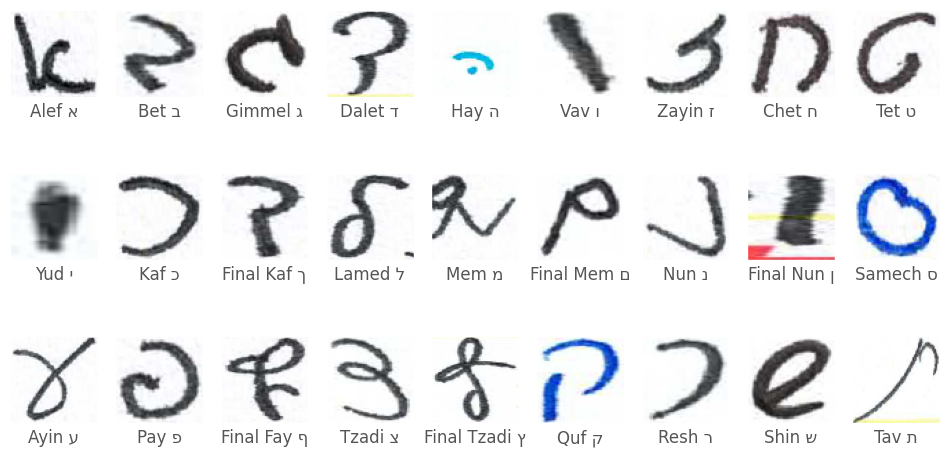

In [7]:
# Initialize a dictionary to store one image per class
class_examples = {}

# Iterate through the dataset
for x, y in train_ds:
    # Convert the label tensor to a numpy array for easier handling
    labels = y.numpy()
    images = x.numpy()

    for image, label in zip(images, labels):
        # If this class is not already saved, add it to the dictionary
        if label not in class_examples:
            class_examples[label] = image
        # Stop if we have one image for each class
        if len(class_examples) == N_classes:
            break
    if len(class_examples) == N_classes:
        break

# Display one sample per class
fig, axes = plt.subplots(3, 9, figsize=(12, 6))
for i, (label, image) in enumerate(sorted(class_examples.items())):
    row, col = divmod(i, 9)
    ax = axes[row, col]
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    label = f"{hebrew_let_name_alph[i][1]} {hebrew_let_name_alph[i][0]}"
    ax.set_xlabel(f"{label}")
    ax.grid(False)
plt.show()


Note: Since UTF only supports the print Hebrew alphabet, the Hebrew letter in the image label text might look different than its corresponding cursive Hebrew image sample right above it. For example, print Tzadi is צ while its cursive counterpart resembles the Arabic numeral 3.

Now that the data is processed and ready to go. I'll also store the train data in cache for faster processing after shuffling for greater randomization.

Additionally, the prefetch() method will allow for faster training since the next batch of data will be fetched while the model is training on the current batch.

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


# Model Selection

Similar to the method described in the paper, I'll use a CNN with two hidden layers. 

I'll use relu for activation and softmax for the final output layer, consistent with multiclass classification.

In [ ]:

X = new_size # all images are 64 X 64

cnn_layers = [Input(shape=(X, X, 3)),
  Conv2D(X//2, (3, 3), activation='relu'),
  MaxPool2D((2,2)),
  Conv2D(X, (3, 3), activation='relu'),
  MaxPool2D((2,2)),
  Flatten(),
  Dense(units=N_classes,activation='softmax', name='Output_Layer')]

model = Sequential(cnn_layers)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 27)             │       338,715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,107 (1.37 MB)

 Trainable params: 358,107 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

Time to compile and train the model for 10 epochs. The researchers did 100 epochs, but that might take too long on my old 2018 Macbook Air.

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.2645 - loss: 2.7147 - val_accuracy: 0.6429 - val_loss: 1.3120
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.7043 - loss: 1.0823 - val_accuracy: 0.6869 - val_loss: 1.1754
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.7929 - loss: 0.8280 - val_accuracy: 0.7108 - val_loss: 1.2278
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.8402 - loss: 0.6107 - val_accuracy: 0.7275 - val_loss: 1.1405
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.8694 - loss: 0.4656 - val_accuracy: 0.7169 - val_loss: 1.2439
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9151 - loss: 0.3461 - val_accuracy: 0.7178 - val_loss: 1.3874
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.9310 - loss: 0.2501 - val_accuracy: 0.7240 - val_loss: 1.4874
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9576 - loss: 0

Looks like I'm getting around 70% validation accuracy! Now to plot the accuracy and loss functions accordingly.

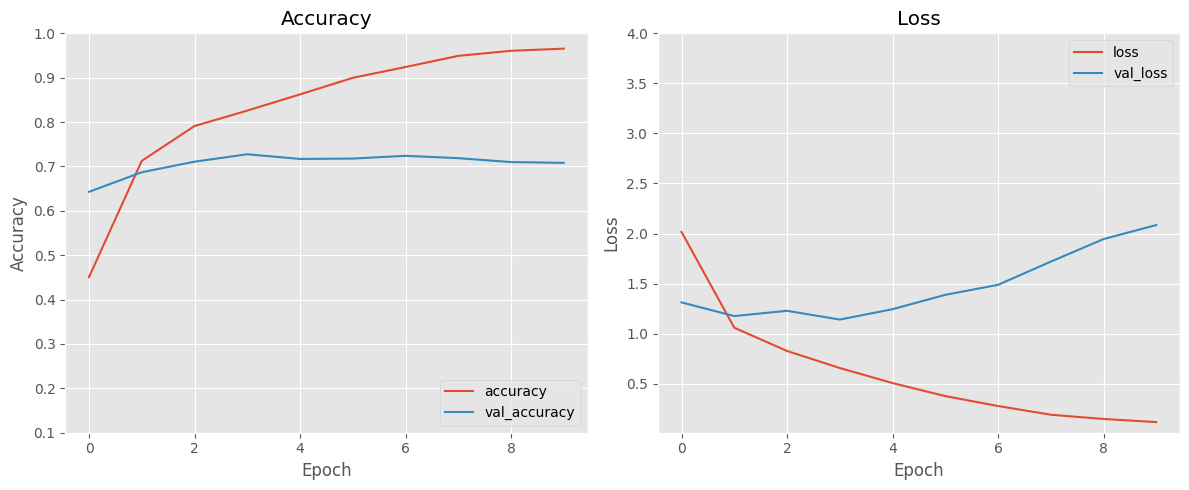

In [14]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1.0])
plt.legend(loc='lower right')
plt.title("Accuracy")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.01, 4.0])
plt.legend(loc='upper right')
plt.title("Loss")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# Evaluation

The results look promising. I'll put together a confusion matrix for a more detailed performance summary.

2025-09-10 11:23:27.408472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/st

2025-09-10 11:23:34.914158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


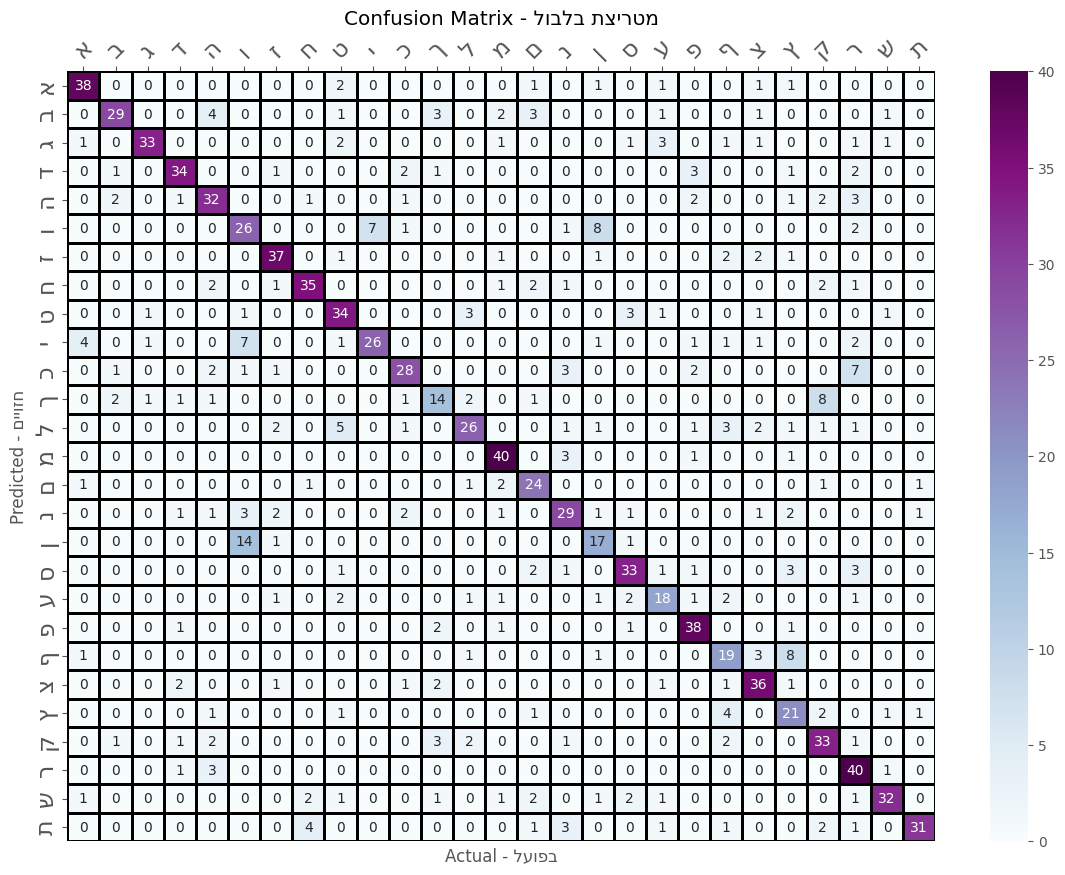

In [18]:
# Get true labels and predictions from the dataset
y_true = tf.concat([labels for _, labels in test_ds], axis=0)  # Combine all true labels
y_pred = tf.concat(
    [tf.argmax(model.predict(images), axis=1) for images, _ in test_ds], axis=0
)  # Combine all predictions

# Compute the confusion matrix
conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=N_classes)

# plot the confusion matrix
heb_conf_mat = "מטריצת בלבול"

heb_pred = "חזויים"

heb_act = "בפועל"

hcf = f"Confusion Matrix - {heb_conf_mat[::-1]}"  

hp = f"Predicted - {heb_pred[::-1]}"

ha = f"Actual - {heb_act[::-1]}" 

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(14, 10))
  ax = sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g',cmap='BuPu',linewidths=1,linecolor='Black')
  
  ax.xaxis.set_ticks_position('top') 
  plt.xticks(rotation=45)  # Rotate x ticks for better readability (optional)
  ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False,labelsize=17)
  
  plt.ylabel(hp)
  plt.title(hcf)
  plt.xlabel(ha)
  plt.show()
  

show_confusion_matrix(conf_matrix,hebrew_letters_alph)

# Discussion

Lots of dark colors along the diagonal indicates satisfactory model performance!

I can see that similar looking letters in the Hebrew alphabet were difficult for the model to properly discern. Specifically, Vav ו and Final Nun ן was a common misclassification. This is expected, as the two letters are both vertical lines with the latter a longer vertical line than the former. 

Other similar looking letter pairings like Yud י, Vav ו and also Quf ק, Final Kaf ך were also misclassified.

Overall, the model performed well, with 70% accuracy across 27 different classes, similar to the results the researchers obtained in the paper.

That's all for this exercise. Some of my ideas for additional functionality at a later date include implementing a sharpening layer in the model, experimenting with different image sizes, and setting up AlexNet and ResNet to further mirror the researchers efforts. Another future endeavor could be attempting to speed up model training by leveraging parallelization.

Thank you so much for viewing this notebook. If you liked what you saw, feel free to follow me on [LinkedIn](https://www.linkedin.com/in/grant-kazan89/) and [Github](https://github.com/grantkazan). 

Special thanks to Irina Rabaev, Berat Kurar Barakat, Alexander Churkin, and Jihad El-Sana; the researchers in Israel who created the Handwritten Hebrew Characters Dataset and presented their findings.

As specified earlier, their paper can be found here:

[The HHD Dataset](https://beratkurar.github.io/papers/icfhr2020_the_hhd_dataset.pdf)

Citation:  I. Rabaev, B. Kurar Barakat, A. Churkin and J. El-Sana. The HHD Dataset. The 17th International Conference on Frontiers in Handwriting Recognition, pp. 228-233, 2020.

